In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

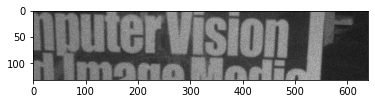

In [36]:
img_raw = cv2.imread("data/20250215-180912/rec_0000.png", cv2.IMREAD_ANYDEPTH).astype(np.float64)
plt.imshow(img_raw, cmap='gray')

In [65]:
gauss_kernel = np.array([
    [ 1, 0, 1, 0, 1],
    [ 0, 0, 0, 0, 0],
    [ 2, 0, 4, 0, 2],
    [ 0, 0, 0, 0, 0],
    [ 1, 0, 2, 0, 1],
])

filterx = np.array([
    [-1, 0, 0, 0, 1],
    [ 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 1],
    [ 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 1],
])
filtery = filterx.T

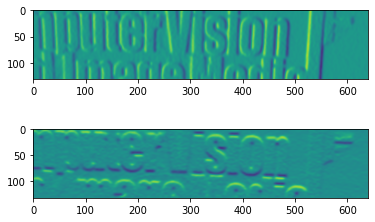

In [66]:
img_raw = cv2.filter2D(img_raw, -1, gauss_kernel)
gx = cv2.filter2D(img_raw, -1, filterx)
gy = cv2.filter2D(img_raw, -1, filtery)
plt.subplot(211)
plt.imshow(gx)
plt.subplot(212)
plt.imshow(gy)

In [67]:
def lucas_kanade(img0, img1):
    # 移動量推定
    mean = img1 + img0
    diff = img1 - img0
    gx = cv2.filter2D(mean, -1, filterx)
    gy = cv2.filter2D(mean, -1, filtery)

    gx2 = np.sum(gx**2)
    gxy = np.sum(gx*gy)
    gy2 = np.sum(gy**2)
    e0  = np.sum(diff*gx)
    e1  = np.sum(diff*gy)

    G = np.array([[gx2, gxy], [gxy, gy2]])
    E = np.array([e0, e1])
    D = np.linalg.solve(G, E)

    dx = -D[0]
    dy = -D[1]
#   print("dx, dy = ", dx, dy)

    # 回転量推定
    w = img0.shape[1]
    h = img0.shape[0]
    cx = (w-1) / 2
    cy = (h-1) / 2
    x, y = np.meshgrid(np.arange(w)-cx, np.arange(h)-cy)
    a = np.sum((-gx*y + gy*x)**2)
    b = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
    c = np.sum((-gx*y + gy*x)*(gx*x + gy*y))
    d = np.sum((gx*x + gy*y)**2)
    e0 = np.sum(diff * (-gx*y + gy*x))
    e1 = np.sum(diff * ( gx*x + gy*y))

    G = np.array([[a, b], [c, d]])
    E = np.array([e0, e1])
    D = np.linalg.solve(G, E)

    dt = D[0]
    ds = -D[1]

    return dx, dy, dt


In [68]:
img0 = cv2.imread("data/20250215-180912/rec_0000.png", cv2.IMREAD_ANYDEPTH)[:,96:224].astype(np.float64)
img1 = cv2.imread("data/20250215-180912/rec_0001.png", cv2.IMREAD_ANYDEPTH)[:,96:224].astype(np.float64)


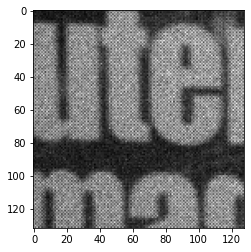

In [69]:
plt.imshow(img0, cmap='gray')

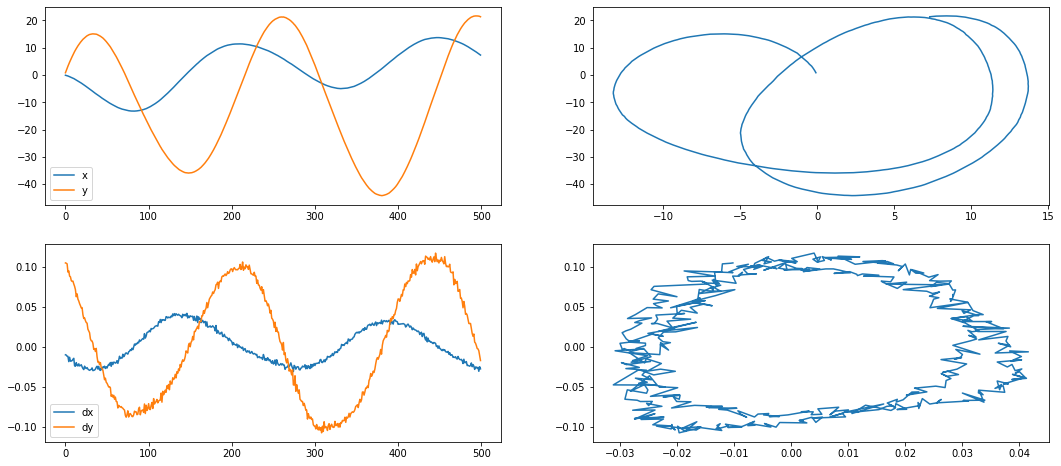

In [70]:
#path = "data/20250215-180912"
path = "data/20250215-180427"

hist_x = []
hist_y = []
hist_dx = []
hist_dy = []

x = 0.0
y = 0.0
for i in range(500):
    file0 = f"{path}/rec_{i:04}.png"
    file1 = f"{path}/rec_{i+1:04}.png"
    img0 = cv2.imread(file0, cv2.IMREAD_ANYDEPTH)[:,96:224].astype(np.float64)
    img1 = cv2.imread(file1, cv2.IMREAD_ANYDEPTH)[:,96:224].astype(np.float64)

    dx, dy, dt = lucas_kanade(img0, img1)
#   print("dx, dy = ", dx, dy)
    x += dx*16
    y += dy*16
    img = cv2.imread(file0)
    cv2.circle(img, (320+int(x), 66+int(y)), 10, (0, 0, 255), -1)
    cv2.imshow("img", img)
    cv2.waitKey(1)
    hist_x.append(x)
    hist_y.append(y)
    hist_dx.append(dx*2)
    hist_dy.append(dy*2)

cv2.destroyAllWindows()

plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(hist_x, label="x")
plt.plot(hist_y, label="y")
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(hist_x, hist_y)
plt.subplot(2, 2, 3)
plt.plot(hist_dx, label="dx")
plt.plot(hist_dy, label="dy")
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(hist_dx, hist_dy)